# Example 2: Train a MOFA model on Multi-Group Data

This notebook shows a simple way to train a MOFA$^1$ model on multi-group and multi-view data. For a basic introduction to Cellij, please have a look at the `example_multi_view.ipynb` notebook first.

We use a chronic lymphocytic leukaemia (CLL) data set, which combined ex vivo drug response measurements with somatic mutation status, transcriptome profiling and DNA methylation assays$^2$.

1: Multi-Omics Factor Analysis-a framework for unsupervised integration of multi-omics data sets by Argelaguet, R. et al. (2018)  
2: Drug-perturbation-based stratification of blood cancer by Dietrich et al. (2018) 

In [1]:
import cellij
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

## Load CLL Data

In [2]:
mdata = cellij.Importer().load_CLL()

#### Preprocess data

In [3]:
# Normalize and log transform MRNA counts
sc.pp.normalize_total(mdata["mrna"], target_sum=1e4)
sc.pp.log1p(mdata["mrna"])

## Run Factor Analysis

In a first experiment, we will just use three views and run the factorization.

In [13]:
# 1. We create a new Factor Analysis model
model = cellij.FactorModel(n_factors=10)

In [14]:
# 2. We add an AnnData object to the model
mdata_3mods = mdata.copy()
del mdata_3mods.mod["mutations"]

In [15]:
model.add_data(mdata_3mods)

#### Assign multiple groups

In [7]:
# The datasets contains male and female mice
display(mdata_3mods.obs["Gender"].value_counts())

# We can indicate this is a grouping parameter to the model
group_m = list(mdata_3mods[mdata_3mods.obs["Gender"] == "m"].obs.index)
group_f = list(mdata_3mods[mdata_3mods.obs["Gender"] != "m"].obs.index)

# We can indicate this is a grouping parameter to the model
model.set_model_options(groups={"group_m": group_m, "group_f": group_f})

m    121
f     79
Name: Gender, dtype: int64

In [8]:
# 3. We train the model
model.fit(epochs=10000)

Training:  57%|█████▋    | 5747/10000 [03:20<02:28, 28.63epoch/s, decrease=0.03 %, loss=191.90]


## Plot Results

#### Plot a heatmap of the weights and factors

In [9]:
weights = model.get_weights(views="all")
factors = model.get_factors(groups="all")

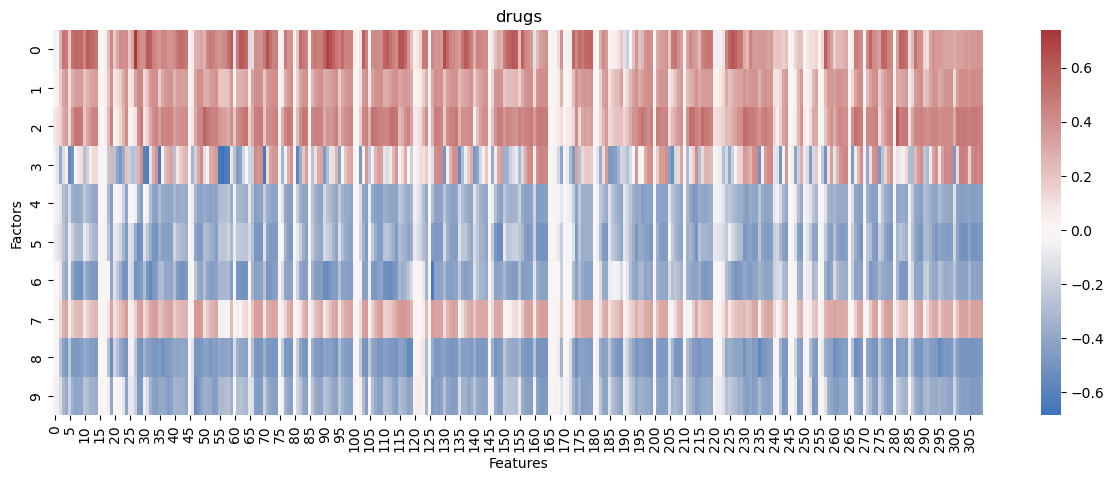

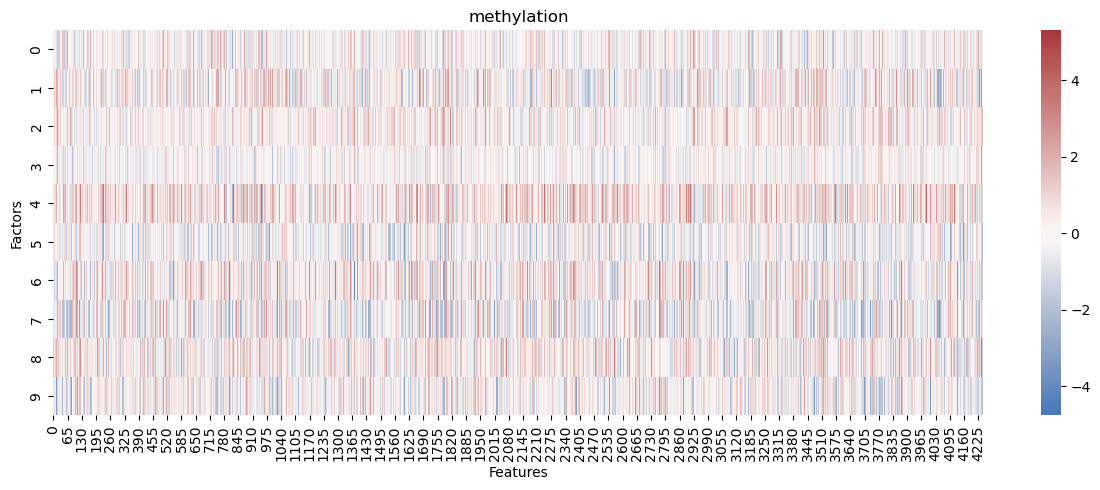

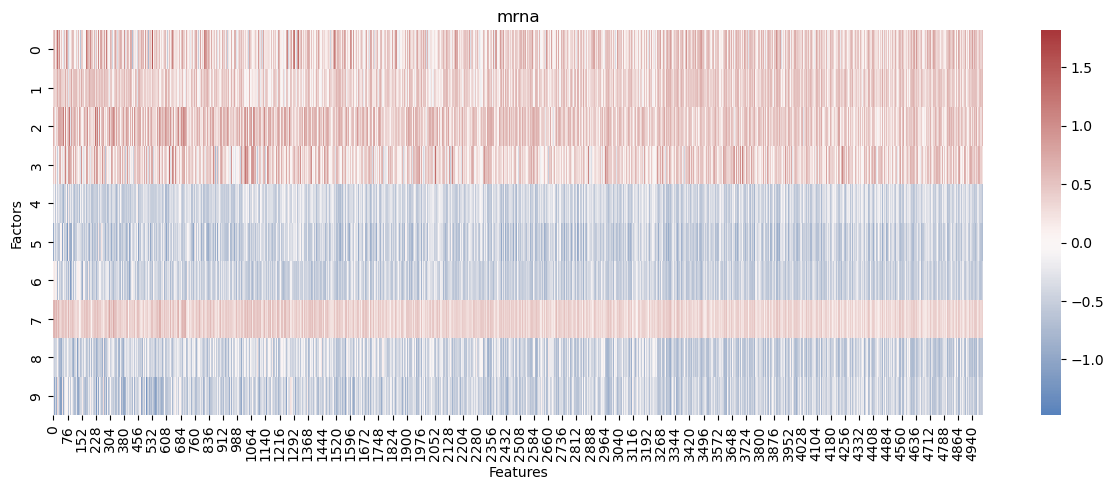

In [10]:
# Let's plot the weights for each modality
for mod, w in weights.items():
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    sns.heatmap(w, cmap="vlag", center=0)
    ax.set_title(mod)
    ax.set_ylabel("Factors")
    ax.set_xlabel("Features")
    plt.show()

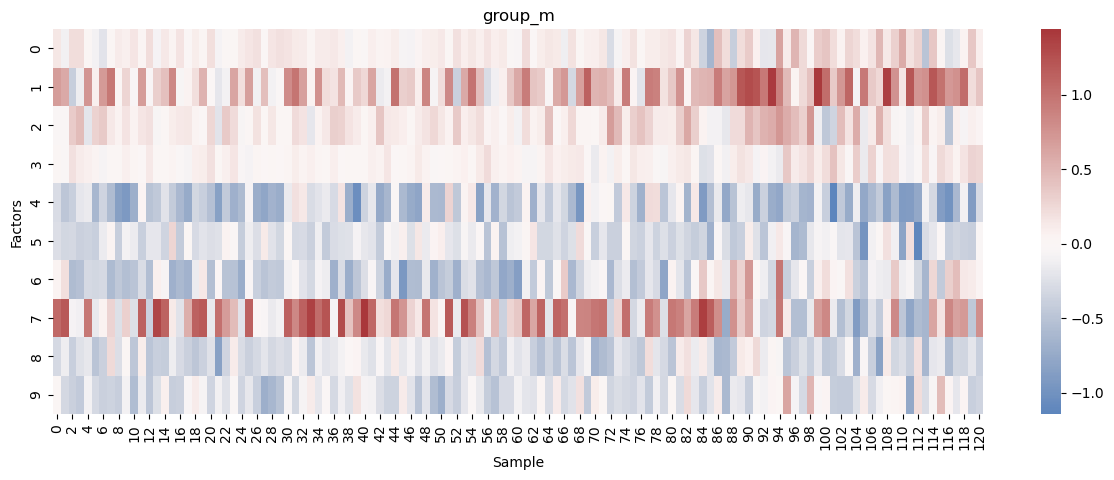

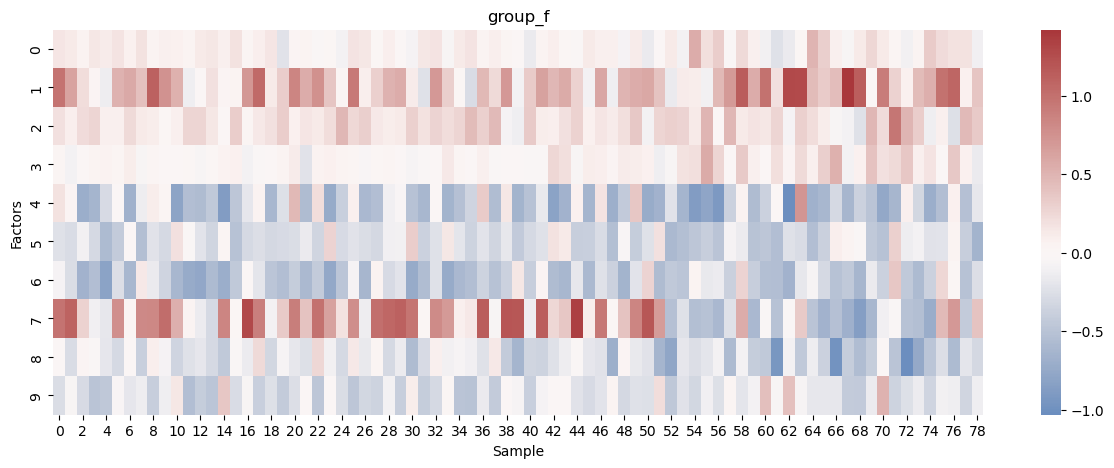

In [11]:
# And our factors
for mod, z in factors.items():
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    sns.heatmap(z.T, cmap="vlag", center=0)
    ax.set_title(mod)
    ax.set_ylabel("Factors")
    ax.set_xlabel("Sample")
    plt.show()

#### ELBO

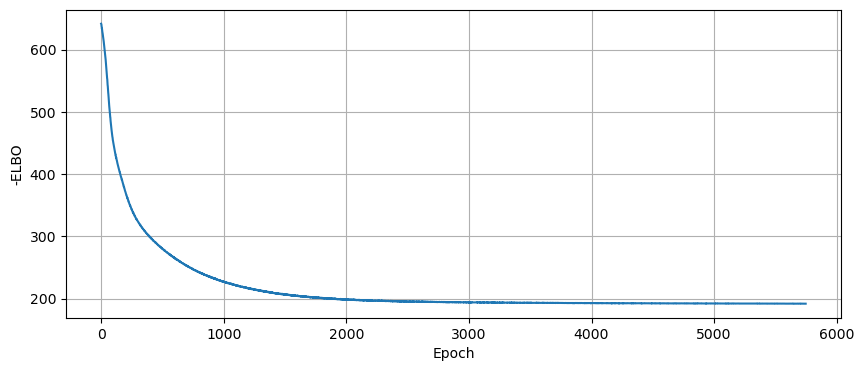

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
plt.plot(model.train_loss_elbo)
plt.xlabel("Epoch")
plt.ylabel("-ELBO")
plt.grid(True)